In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle as pkl
import sys
import matplotlib.pyplot as plt
from torchvision import utils
sys.path.append('../..')
from evaluation.scripts.challenge_eval import run_bg_challenge
from pytorch_lightning.callbacks import Callback
from data.bgc_eval_datasets import ImageNet9

class AutopickleModel(Callback): #Thing that was helping with pickling is also messing up pickling, how delightful
    def __init__(self, model):
        self.model = model

    def on_validation_epoch_end(self, trainer, module):
        model_file = open(args.save_path, 'wb')
        # The base model should not need it anymore- and it's a bit messing up pickling
        self.model.base_model.train_dataloader = None
        self.model.base_model.val_dataloader = None
        self.model.base_model.trainer = None
        pkl.dump(self.model, model_file)
        model_file.close()

In [2]:
MODEL_PATHS = ['/home/macron/Praca Magisterska/Gotowe Sieci/clean.pkl',
               #'/home/macron/Praca Magisterska/Gotowe Sieci/flow_3ep_start_epclear_nolimit.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_77ep_256emb_conv.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_77ep_nf.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_30ep_nf.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_30ep_100emb_conv.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_77ep_256emb_512z.pkl']
               #'/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_30ep_100emb.pkl',
               #'/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_77ep_256emb.pkl']
cached = {'clean' : 6.74,
          'flow_nice_77ep_256emb_conv' : 0.0, 'flow_nice_77ep_nf' : 34.839506172839506,
          'flow_nice_30ep_nf' : 33.08641975308642, 'flow_nice_30ep_100emb_conv' : 0.0, 'flow_nice_77ep_256emb_512z' : 13.703703703703706}
force = False

ORIGINAL_PATH = '/home/macron/Praca Magisterska/BGC Dane/original/val/'
FOREGROUND_PATH = '/home/macron/Praca Magisterska/BGC Dane/fg_mask/val/'

bg_ds = ImageNet9(f'/home/macron/Praca Magisterska/BGC Dane/only_bg_t')
bg_loader = bg_ds.make_loaders(batch_size=16, workers=8)

results = {}
for path in MODEL_PATHS:
    model_name = path.split('/')[-1].replace('.pkl', '')
    if model_name in cached and not force:
        results[model_name] = cached[model_name]
        continue
    model_file = open(path, 'rb')
    print(model_name)
    model = pkl.load(model_file)
    model_file.close()
    model.cuda()
    model.eval()
    avg = (1 - run_bg_challenge(model, bg_loader, ORIGINAL_PATH, FOREGROUND_PATH)) * 100
    
    print(f'Model {model_name}: {avg}')
    results[model_name] = avg

==> Preparing dataset ImageNet9..
flow_nice_77ep_256emb_512z



  0%|                                                  | 0/4050 [00:00<?, ?it/s]

00_dog
0


vulnerable: 59/450:  11%|██                | 450/4050 [48:24<6:47:13,  6.79s/it]

01_bird
1


vulnerable: 509/900:  22%|████▏              | 900/4050 [53:19<33:37,  1.56it/s]

02_wheeled vehicle
2


vulnerable: 959/1350:  33%|█████▋           | 1350/4050 [58:37<30:14,  1.49it/s]

03_reptile
3


vulnerable: 1312/1800:  44%|█████▎      | 1800/4050 [1:19:24<2:19:06,  3.71s/it]

04_carnivore
4


vulnerable: 1762/2250:  56%|███████▊      | 2250/4050 [1:24:11<18:37,  1.61it/s]

05_insect
5


vulnerable: 2212/2700:  67%|█████████▎    | 2700/4050 [1:29:01<14:22,  1.56it/s]

06_musical instrument
6


vulnerable: 2607/3150:  78%|██████████▉   | 3150/4050 [1:43:01<14:33,  1.03it/s]

07_primate
7


vulnerable: 3046/3600:  89%|████████████▍ | 3600/4050 [1:51:38<04:55,  1.52it/s]

08_fish
8


vulnerable: 3495/4050: 100%|██████████████| 4050/4050 [1:57:23<00:00,  1.74s/it]

Model flow_nice_77ep_256emb_512z: 13.703703703703706


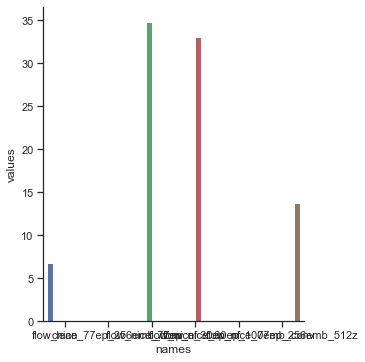

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

names = []
values = []
for md in results:
    names.append(md)
    values.append(results[md])

sns.catplot(x="names", y="values", hue="names", kind="bar", data=pd.DataFrame({'names' : names, 'values' : values}))